# Преобразование Фурье

Рассмотреть сигнал  синусоидальной формы с частотой 120 Гц, Амплитудой 1 В. Отсчеты сигнала реализовать через каждую миллисекунду. Длина выборки 1000 отсчетов.  Получить Фурье-образ сигнала в зависимости от частоты отсчетов. Определить амплитуду Фурье-гармоники на частоте 120 Гц. Сравнить в амплитудой, которая была бы получена аналитическим путем.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from matplotlib.animation import FuncAnimation

plt.rcParams['font.serif'] = ['Hack']

Амплитуда по FFT: 0.9999999999999999
Аналитическая амплитуда: 1.0
Разность: 1.1102230246251565e-16


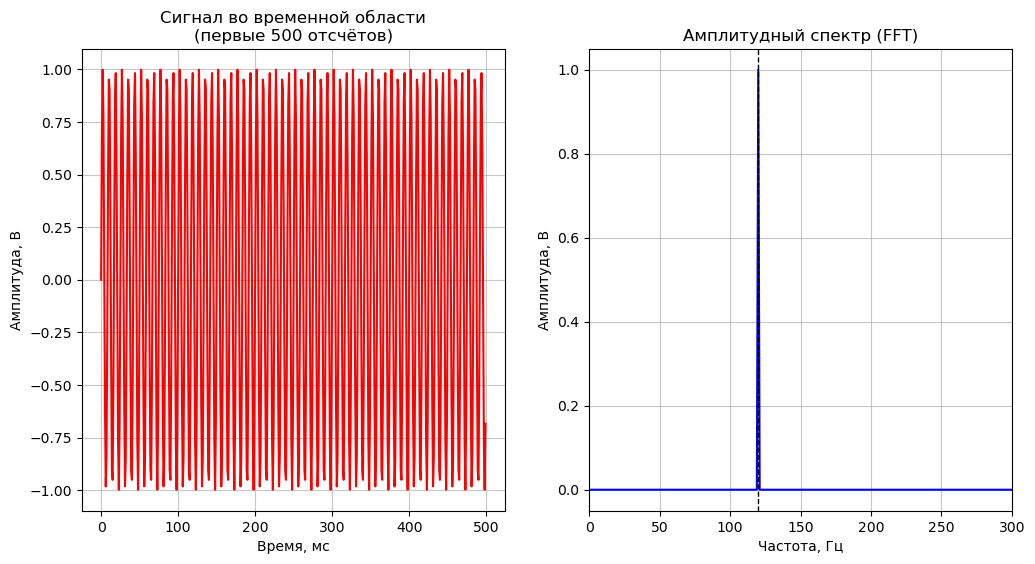

In [2]:
freq = 120 # Гц
ampl = 1.0 # В
dt = 0.001 # период дисректизации, с
N = 1000 # длина выборки 
nu = 1 / dt # частота дискретизации


t = np.arange(N) * dt
signal = ampl * np.sin(2 * np.pi * freq * t) # записали нашу синусоиду

# фурим и выделяем частоты
fft_signal = np.fft.fft(signal) 
fft_signal_freqs = np.fft.fftfreq(N, d=dt) 

# амплитудный спектр (модуль FFT, нормированный на N)
ampl_spectrum = np.abs(fft_signal) / N 

# находим индекс бина, соответствуюещго 120 Герцам
target_bin = np.argmin(np.abs(fft_signal_freqs - freq))
ampl_fft = ampl_spectrum[target_bin] * 2 

print(f"Амплитуда по FFT: {ampl_fft}")
print(f"Аналитическая амплитуда: {ampl}")
print(f"Разность: {abs((ampl_fft - ampl))}")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pos_freqs = fft_signal_freqs[:N//2]
pos_amp = ampl_spectrum[:N//2] * 2

ax[0].plot(t[:500] * 1000, signal[:500], color='red')
ax[0].set_title('Сигнал во временной области\n(первые 500 отсчётов)')
ax[0].set_xlabel('Время, мс')
ax[0].set_ylabel('Амплитуда, В')
ax[0].grid(True, alpha=0.7)

ax[1].plot(pos_freqs, pos_amp, color='blue')
ax[1].set_title('Амплитудный спектр (FFT)')
ax[1].set_xlabel('Частота, Гц')
ax[1].set_ylabel('Амплитуда, В')
ax[1].set_xlim(0, 300)
ax[1].axvline(freq, color='black', linestyle='--', linewidth=1, label=f'{freq} Гц')
ax[1].grid(True, alpha=0.7)

Для передачи информации по кабелю используется серия импульсов прямоугольной формы, амплитудой 1 В. На втором конце кабеля стоит приемник, который считает сигнал выше 0.8 В единицей, а ниже 0.2 В нулем. Кабельная линии имеет зависимость скорости прохождения отдельных гармоник сигнала от частоты (загрузить из файла). Определить максимальную частоту передаваемого сигнала по линии длиной 10 м, 100 м, 1 км.  (два соседних импульса не должны перекрываться.)

In [26]:
T = 1/5000 # период дискретизации
N = 1000 # N точек
V0 = 3 * 10**10

frequencies = [50, 150, 250, 350, 777, 1000, 522]  # основная частота + гармоники
amplitudes =  [1.0, 0.3, 0.2, 0.1, 0.7, 0.3, 0.123]   # амплитуды гармоник
cable_length = 100000
cable_lengths = [10, 100, 1000, 5000]
duration = 0.1

def sin_signal(freq, N, T, Ampl):
    x = np.linspace(0, N * T, N, endpoint=False)
    y = Ampl * np.sin(2 * np.pi * freq * x)
    return x, y

def square_impulse(width, position, N, T, A):
    x = np.linspace(0, N * T, N, endpoint=False)
    y = np.zeros(N)
    start_idx = int(position / T)
    end_idx = int((position + width) / T)
    y[start_idx:end_idx] = A
    return x, y


def cable_dispersion(freq):
    return V0 / np.sqrt(1 + 1000000/np.maximum(np.abs(freq), 1e-10))

def propagate(signal_time, cable_length, dt):
    n = len(signal_time)
    signal_freq = fft(signal_time)
    freqs = fftfreq(n, dt)

    signal_freq_dispersed = np.zeros_like(signal_freq, dtype=complex)
    
    for i, freq in enumerate(freqs):

        v_phase = cable_dispersion(freq) # скорость данной частоты
        k = 2 * np.pi * freq / v_phase if v_phase != 0 else 0 # волновое число k = 2πf/v
        phase_shift = np.exp(-1j * k * cable_length) # фазовый сдвиг
        signal_freq_dispersed[i] = signal_freq[i] * phase_shift
    
    signal_dispersed = np.real(ifft(signal_freq_dispersed))
    
    return signal_dispersed, freqs, signal_freq

def create_complex_signal(frequencies, amplitudes, duration, N, T):
    t = np.linspace(0, duration, N, endpoint=False)
    signal = np.zeros(N)
    
    for freq, amp in zip(frequencies, amplitudes):
        _, harmonic = sin_signal(freq, N, T, amp)
        signal += harmonic
    
    return t, signal

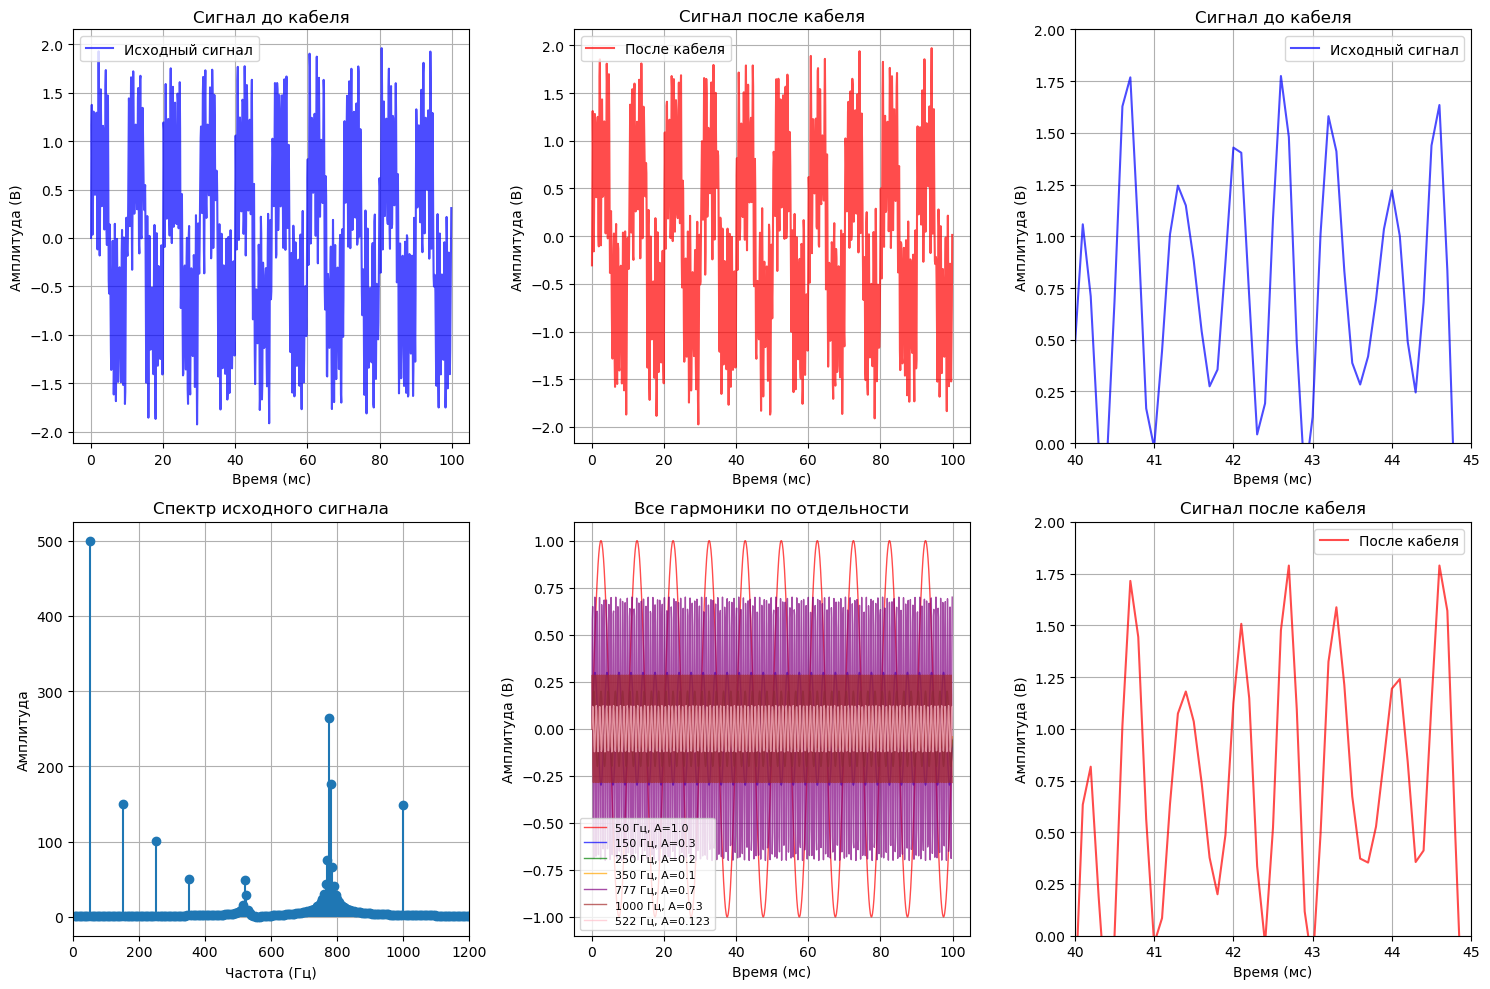

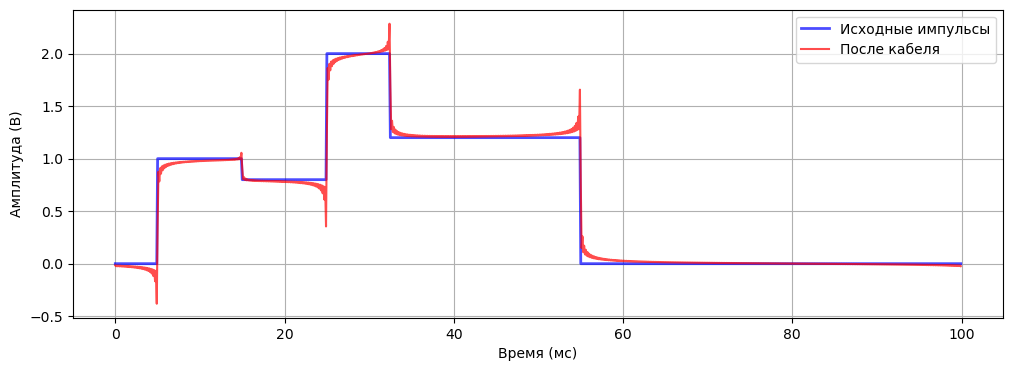

In [27]:
t, complex_signal = create_complex_signal(frequencies, amplitudes, duration, N, T)

complex_dispersed, freqs, spectrum = propagate(complex_signal, cable_length, T)

fig, ((ax1, ax2, ax5), (ax3, ax4, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

ax1.plot(t * 1000, complex_signal, 'b-', alpha=0.7, label='Исходный сигнал', linewidth=1.5)
ax1.set_title('Сигнал до кабеля')
ax1.set_xlabel('Время (мс)')
ax1.set_ylabel('Амплитуда (В)')
ax1.legend()
ax1.grid(True)

ax2.plot(t * 1000, complex_dispersed, 'r-', alpha=0.7, label='После кабеля', linewidth=1.5)
ax2.set_title('Сигнал после кабеля')
ax2.set_xlabel('Время (мс)')
ax2.set_ylabel('Амплитуда (В)')
ax2.legend()
ax2.grid(True)

positive_mask = freqs > 0
positive_freqs = freqs[positive_mask]
positive_spectrum = np.abs(spectrum[positive_mask])

ax3.stem(positive_freqs, positive_spectrum, basefmt=" ")
ax3.set_title('Спектр исходного сигнала')
ax3.set_xlabel('Частота (Гц)')
ax3.set_ylabel('Амплитуда')
ax3.grid(True)
ax3.set_xlim(0, 1200)  

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
for i, (freq, amp) in enumerate(zip(frequencies, amplitudes)):
    _, harmonic = sin_signal(freq, N, T, amp)
    ax4.plot(t * 1000, harmonic, color=colors[i % len(colors)], 
             alpha=0.7, label=f'{freq} Гц, A={amp}', linewidth=1)

ax4.set_title('Все гармоники по отдельности')
ax4.set_xlabel('Время (мс)')
ax4.set_ylabel('Амплитуда (В)')
ax4.legend(fontsize=8)
ax4.grid(True)

ax5.plot(t * 1000, complex_signal, 'b-', alpha=0.7, label='Исходный сигнал', linewidth=1.5)
ax5.set_title('Сигнал до кабеля')
ax5.set_xlim(40, 45)
ax5.set_ylim(0, 2)
ax5.set_xlabel('Время (мс)')
ax5.set_ylabel('Амплитуда (В)')
ax5.legend()
ax5.grid(True)

ax6.plot(t * 1000, complex_dispersed, 'r-', alpha=0.7, label='После кабеля', linewidth=1.5)
ax6.set_title('Сигнал после кабеля')
ax6.set_xlabel('Время (мс)')
ax6.set_ylabel('Амплитуда (В)')
ax6.set_xlim(40, 45)
ax6.set_ylim(0, 2)
ax6.legend()
ax6.grid(True)

plt.tight_layout()
plt.show()

def create_pulse_signal(duration, N, T):
    t = np.linspace(0, duration, N, endpoint=False)
    signal = np.zeros(N)
    
    pulse_params = [(0.01, 0.02, 1.0), (0.03, 0.035, 0.8), (0.05, 0.06, 1.2)]
    
    for start, width, amplitude in pulse_params:
        _, pulse = square_impulse(width, start, N, T, amplitude)
        signal += pulse
    
    return t, signal

t_pulse, pulse_signal = create_pulse_signal(duration, N, T)
pulse_dispersed, _, _ = propagate(pulse_signal, cable_length, T)

plt.figure(figsize=(12, 4))
plt.plot(t_pulse * 1000, pulse_signal, 'b-', alpha=0.7, label='Исходные импульсы', linewidth=2)
plt.plot(t_pulse * 1000, pulse_dispersed, 'r-', alpha=0.7, label='После кабеля', linewidth=1.5)
plt.xlabel('Время (мс)')
plt.ylabel('Амплитуда (В)')
plt.legend()
plt.grid(True)
plt.show()

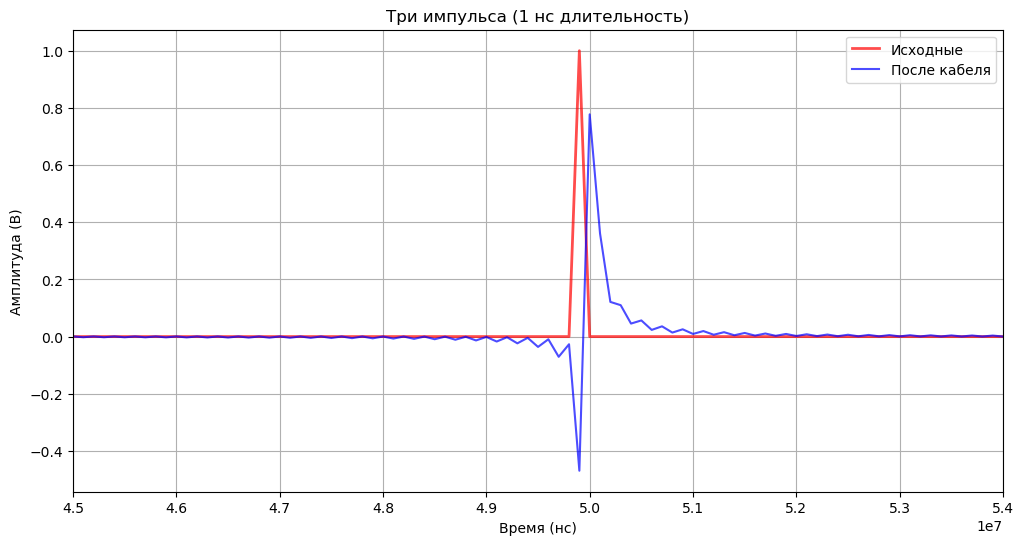

In [28]:
# Используем микросекундные импульсы с текущей частотой дискретизации
T = 1/50000
N = 1000
duration = 0.1

t = np.linspace(0, duration, N, endpoint=False)

_, pulse1 = square_impulse(1e-9, 0.01, N, T, 1.0)      
_, pulse2 = square_impulse(1e-9, 0.014, N, T, 1.0)     
_, pulse3 = square_impulse(1e-9, 0.016, N, T, 1.0)     

pulses_signal = pulse1 + pulse2 + pulse3

pulses_dispersed, _, _ = propagate(pulses_signal, cable_length, T)

plt.figure(figsize=(12, 6))
plt.plot(t * 1e9, pulses_signal, alpha=0.7, label='Исходные', markersize=4, color='red', linewidth=2)
plt.plot(t * 1e9, pulses_dispersed, alpha=0.7, label='После кабеля', markersize=3, color='blue', linewidth=1.5)
plt.title('Три импульса (1 нс длительность)')
plt.xlabel('Время (нс)')
plt.ylabel('Амплитуда (В)')
plt.legend()
plt.xlim(0.45e8, 0.54e8)
plt.grid(True)